In [1]:
from pathlib import Path

import os
import math
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import spyrit.core.meas as meas
import spyrit.core.noise as noise
import spyrit.core.prep as prep
import spyrit.core.recon as recon
import spyrit.core.nnet as nnet
import spyrit.core.train as train
import spyrit.misc.statistics as stats
import spyrit.external.drunet as drunet
from spyrit.core.recon import PinvNet


from spyrit.misc.disp import add_colorbar, noaxis
from spyrit.misc.statistics import Cov2Var
from spyrit.misc.sampling import sort_by_significance

- Define Choose_pattern_order function for pattern order generation

In [2]:

def choose_pattern_order(order_name, img_size):
    np.random.seed(seed=0)
    # print('stat_folder_full',stat_folder_full)
    M = img_size ** 2 // 4  # Number of measurements (1/4 of the pixels)
    if order_name == 'low_freq':
        M_xy = math.ceil(M**0.5)
        Ord_rec = np.ones((img_size, img_size))

        Ord_rec[:,M_xy:] = 0
        Ord_rec[M_xy:,:] = 0

    elif order_name == 'naive':
        Ord_rec = np.ones((img_size, img_size))

    elif order_name == 'variance':
        # if img_size == 128:
        #      cov_name = f'Cov_8_{img_size}x{img_size}.npy'
        # else:
        #     cov_name = f'Cov_{img_size}x{img_size}.npy'

        # cov_path =  os.path.join(stat_folder_full, cov_name)
        # print(f"Loading covariance matrix from: {cov_path}")
        # Cov = np.load(cov_path)
        # Cov = np.ones((img_size, img_size))
        # print(f"Cov matrix {cov_name} loaded")
        # print ("the size of the cov matrix", Cov.shape)
        # Ord_rec = Cov2Var(Cov)
        # print("the size of the Ord_rec", Ord_rec.shape)

        if img_size == 128:
            cov_name = 'Cov_8_%dx%d.npy' % (img_size, img_size)
        else:
            cov_name = 'Cov_%dx%d.npy' % (img_size, img_size)

        Cov = np.load(stat_folder_full / Path(cov_name))
        print(f"Cov matrix {cov_name} loaded")

        Ord_rec = Cov2Var(Cov)
        print("the size of the Ord_rec", Ord_rec.shape)


    elif order_name == 'random':
    #     set random pixel of the Ord_rec to 1
        # Initialize a 64x64 matrix with zeros
        matrix = np.zeros((img_size, img_size), dtype=int)
        
        # Flatten the matrix to work with indices
        flat_indices = np.arange(matrix.size)  # Create an array of indices [0, 1, ..., 4095]
        
        # Randomly choose M_xy**2 unique indices to be set to 1
        M_xy = math.ceil(M**0.5)
        random_indices = np.random.choice(flat_indices, size=M_xy**2, replace=False)
        
        # Set the chosen indices to 1
        matrix.flat[random_indices] = 1
        
        # Verify the result
        print("Matrix shape:", matrix.shape)
        print("Number of elements set to 1:", np.sum(matrix))        
        Ord_rec = matrix
    elif order_name == 'random_variance':
    #     # TODO 
        # set a recontruction in high frequencies
         # Initialize a 64x64 matrix with zeros
        matrix = np.zeros((img_size, img_size), dtype=int)
         # Flatten the matrix to work with indices
        flat_indices = np.arange(matrix.size)  # Create an array of indices [0, 1, ..., 4095]
        
    elif order_name=='high_freq':
        M_xy = math.ceil(M**0.5)
        Ord_rec = np.ones((img_size, img_size))

        Ord_rec[:,:M_xy] = 0
        Ord_rec[:M_xy,:] = 0



    
    elif order_name == '70_lf':
        # M_xy = math.ceil(M**0.5)
        quad_size=int(img_size/2)
        # print("quad_size",quad_size)
        first_quadrant= np.zeros((quad_size,quad_size))
        second_quadrant= np.zeros((quad_size,quad_size))
        third_quadrant= np.zeros((quad_size,quad_size))
        fourth_quadrant= np.zeros((quad_size,quad_size))
        S=first_quadrant.size
        first_ones_to_keep=int(M*0.7)
        second_ones_to_keep=int(M*0.1)
        third_ones_to_keep=int(M*0.1)
        fourth_ones_to_keep=int(M*0.1)
        indices1 = np.random.choice(S, first_ones_to_keep, replace=False)
        indices2 = np.random.choice(S, second_ones_to_keep, replace=False)
        indices3 = np.random.choice(S, third_ones_to_keep, replace=False)
        indices4 = np.random.choice(S, fourth_ones_to_keep, replace=False)
        
        # first_quadrant.flatten()[indices1]=1

        # Modify the original array using its flat iterator
        first_quadrant.flat[indices1] = 1
        second_quadrant.flat[indices2] = 1
        third_quadrant.flat[indices3] = 1
        fourth_quadrant.flat[indices4] = 1

        # Initialize the full image
        Ord_rec = np.zeros((img_size, img_size))

        Ord_rec[:quad_size,:quad_size] = first_quadrant
        Ord_rec[:quad_size,quad_size:] = second_quadrant
        Ord_rec[quad_size:,:quad_size] = third_quadrant
        Ord_rec[quad_size:,quad_size:] = fourth_quadrant

    elif order_name == '70_lfcorr':
        quad_size=int(img_size/2)
        eighth_size=int(quad_size/2)
        num_samples_q1= int(M*0.7)
        num_samples_q2= int(M*0.1)
        num_samples_q3= int(M*0.1)
        num_samples_q4= int(M*0.1)
        # print("M=",M)
        
        # print("samples1",num_samples_q1+num_samples_q2+num_samples_q3+ num_samples_q4)
        num_samples_q1=num_samples_q1 + (M-(num_samples_q1+num_samples_q2+num_samples_q3+ num_samples_q4))
        # print("samples2",num_samples_q1+num_samples_q2+num_samples_q3+ num_samples_q4)
        
        first_quadrant= np.zeros((quad_size,quad_size))
        second_quadrant= np.zeros((quad_size,quad_size))
        third_quadrant= np.zeros((quad_size,quad_size))
        fourth_quadrant= np.zeros((quad_size,quad_size))

        first_eighth =np.ones((eighth_size,eighth_size))
        e2,e3,e4 =np.zeros((eighth_size,eighth_size)),np.zeros((eighth_size,eighth_size)),np.zeros((eighth_size,eighth_size))
        q1_samples_rem=num_samples_q1-first_eighth.size
        # print("q1_saples_rem=",q1_samples_rem)
        # print("q1_samples=",num_samples_q1)
        # print("first_eighth.size",first_eighth.size)
        e2_samples,e3_samples,e4_samples = int(q1_samples_rem/3),int(q1_samples_rem/3),int(q1_samples_rem/3)
        e4_samples=e4_samples+(q1_samples_rem-(e2_samples+e3_samples+e4_samples))
        # print("rest=", num_samples_q1-(first_eighth.size+e2_samples+e3_samples+e4_samples))
        indices_e2=np.random.choice(first_eighth.size, e2_samples, replace=False)
        indices_e3=np.random.choice(first_eighth.size, e3_samples, replace=False)
        indices_e4=np.random.choice(first_eighth.size, e4_samples, replace=False)
        e2.flat[indices_e2] = 1
        e3.flat[indices_e3] = 1
        e4.flat[indices_e4] = 1
        first_quadrant[:eighth_size,:eighth_size] = first_eighth
        first_quadrant[:eighth_size,eighth_size:] = e2
        first_quadrant[eighth_size:,:eighth_size] = e3
        first_quadrant[eighth_size:,eighth_size:] = e4
        S= first_quadrant.size
        indices_q2 = np.random.choice(S, num_samples_q2, replace=False)
        indices_q3 = np.random.choice(S, num_samples_q3, replace=False)
        indices_q4 = np.random.choice(S, num_samples_q4, replace=False)
    

        # Modify the original array using its flat iterator
        second_quadrant.flat[indices_q2] = 1
        third_quadrant.flat[indices_q3] = 1
        fourth_quadrant.flat[indices_q4] = 1

        # Initialize the full image
        
        Ord_rec = np.zeros((img_size, img_size))

        Ord_rec[:quad_size,:quad_size] = first_quadrant
        Ord_rec[:quad_size,quad_size:] = second_quadrant
        Ord_rec[quad_size:,:quad_size] = third_quadrant
        Ord_rec[quad_size:,quad_size:] = fourth_quadrant
        # print("rest_total=",np.count_nonzero(Ord_rec))


    else:
        print('Order name is invalid')
        exit(1)

    return Ord_rec

- SET CWD NAMES
ajuster cela pour que project root soit \2024_tdsi\à la fin 

In [10]:

# Dynamically set the project root based on the file's location
current_file = Path.cwd()
project_root = current_file.parents[0]  # Adjust the number to match your directory structure


# Set the working directory to the project root
os.chdir(project_root)

# Add project root to sys.path for module imports
import sys
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Confirm
print(f"Project root set to: {project_root}")
print(f"Current working directory: {Path.cwd()}")

# General
# --------------------------------------------------------------------
# Experimental data
image_folder = 'data/images/'       # images for simulated measurements
model_folder = 'model/'             # reconstruction models
stat_folder  = 'stat/'              # statistics

# Full paths
image_folder_full = Path.cwd() / Path(image_folder)
model_folder_full = Path.cwd() / Path(model_folder)
stat_folder_full  = Path.cwd() / Path(stat_folder)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Project root set to: c:\Users\marti\OneDrive - INSA Lyon\5GE\TDSI\Projet\fork_sami\image_recontruction_ML-1\2024_tdsi
Current working directory: c:\Users\marti\OneDrive - INSA Lyon\5GE\TDSI\Projet\fork_sami\image_recontruction_ML-1\2024_tdsi
Using device: cpu


Loading image...
Image shape: torch.Size([1, 1, 64, 64])
value of the image -0.11372548


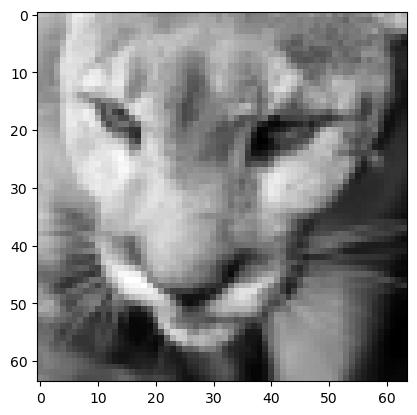

In [11]:
img_size = 64
alpha = 10 # Poisson law parameter for noisy image acquisitions
subsampling_factor = 4
M = img_size ** 2 // subsampling_factor  # Number of measurements (1/4 of the pixels)
print("Loading image...")
# crop to desired size, set to black and white, normalize
transform = stats.transform_gray_norm(img_size)

# define dataset and dataloader. `image_folder_full` should contain
# a class folder with the images
dataset = torchvision.datasets.ImageFolder(
    image_folder_full, 
    transform=transform
    )

dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=10, 
    shuffle=False
    )

# select the image
x, _ = next(iter(dataloader))
x = x[1].unsqueeze(0)
b, c, h, w = x.shape # batch size, channels, height, width
print("Image shape:", x.shape)

x_plot = x.view(-1, h, h).cpu().numpy()# reshape to h x h

plt.imshow(x_plot.squeeze(), cmap="gray")
print("value of the image",x_plot[0,40,40])

- Start testing printing different order_rec

In [14]:
# Simulate measurements for three image intensities
# --------------------------------------------------------------------
# Measurement parameters
# alpha_list = [2, 10, 50] # Poisson law parameter for noisy image acquisitions
alpha = 10 # Poisson law parameter for noisy image acquisitions
img_size = 64
h=img_size
und = 4
M = img_size ** 2 // und  # Number of measurements (here, 1/4 of the pixels)

#order_name = 'low_freq'
#order_name = 'naive'
#order_name = 'high_freq'
#order_name = 'variance'
#order_name = 'random'
# order_name = 'random_variance'
# order_name = 'random_variance_2'
# order_name = 'random_variance_3'
# order_name='70_lf'
order_name='70_lfcorr'


number of ones in Ord_rec= 1024.0 
M= 819
size of the variance vector (64, 64)


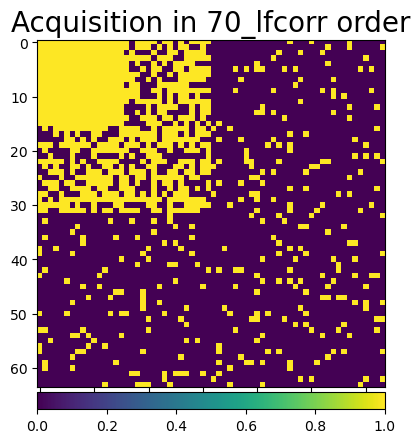

In [15]:
Ord_rec = choose_pattern_order(order_name, img_size)
count_ones= np.sum(Ord_rec)
print("number of ones in Ord_rec=",count_ones,"\nM=",(int(0.8*M)))

# Mask of order
mask_basis = np.zeros((h, h))
mask_basis.flat[:M] = 1 # M valeurs qui sont égales à 1
print("size of the variance vector",Ord_rec.shape)
mask = sort_by_significance(mask_basis, Ord_rec, axis="flatten")

im = plt.imshow(mask)
plt.title("Acquisition in " + order_name + " order", fontsize=20)
add_colorbar(im, "bottom", size="20%")

- Reconstruct image with Psuedo-Inverse

In [20]:
# Measurement and noise operators
meas_op = meas.HadamSplit(M, h, torch.from_numpy(Ord_rec))
noise_op = noise.Poisson(meas_op)
prep_op = prep.SplitPoisson(alpha, meas_op)

 
# Measurement vectors
torch.manual_seed(0)    # for reproducibility
noise_op.alpha = alpha
print ("shape of x", x.shape)
print ("measurment operator" , meas_op.H_pinv.shape)# c'est la pseudo inverse
y = noise_op(x)


shape of x torch.Size([1, 1, 64, 64])
measurment operator torch.Size([4096, 1024])
torch.Size([1, 1, 2048])


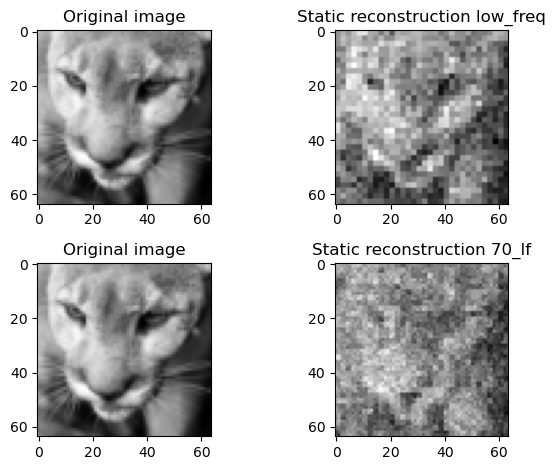

In [21]:
# PLOTTING THE MEASURED IMAGE
figure, axis = plt.subplots(2, 2)
with torch.no_grad():
    axis[0,0].imshow(x_plot.squeeze(), cmap="gray")
    axis[0,0].set_title('Original image')
    axis[1,0].imshow(x_plot.squeeze(), cmap="gray")
    axis[1,0].set_title('Original image')
        # Measurement and noise operators
    meas_op = meas.HadamSplit(M, h, torch.from_numpy(choose_pattern_order("low_freq",img_size)))
    noise_op = noise.Poisson(meas_op)
    prep_op = prep.SplitPoisson(alpha, meas_op)
    # Measurement vectors
    torch.manual_seed(0)    # for reproducibility
    noise_op.alpha = alpha
    # print ("shape of x", x.shape)
    # print ("measurment operator" , meas_op.H_pinv.shape)# c'est la pseudo inverse
    y = noise_op(x)
    m = prep_op(y)
    f_stat = meas_op.pinv(m)
    axis[0,1].imshow(f_stat.view(h, w).cpu().numpy(), cmap='gray')
    axis[0,1].set_title('Static reconstruction low_freq')


    meas_op = meas.HadamSplit(M, h, torch.from_numpy(choose_pattern_order("70_lf",img_size)))
    noise_op = noise.Poisson(meas_op)
    prep_op = prep.SplitPoisson(alpha, meas_op)
    # Measurement vectors
    torch.manual_seed(0)    # for reproducibility
    noise_op.alpha = alpha
    # print ("shape of x", x.shape)
    # print ("measurment operator" , meas_op.H_pinv.shape)# c'est la pseudo inverse
    y = noise_op(x)
    m = prep_op(y)
    f_stat = meas_op.pinv(m)
    axis[1,1].imshow(f_stat.view(h, w).cpu().numpy(), cmap='gray')
    axis[1,1].set_title('Static reconstruction 70_lf')
    plt.tight_layout()
# plt.imshow ( meas_op.H[1023,:].reshape(img_size, img_size))
# print ("taille de H", meas_op.H.shape)

- Reconstruct Image with a UNET

Model Loaded: model/pinv-net_BF_Unet_weight_decay_stl10_N0_10_N_64_M_1024_epo_50_lr_0.001_sss_10_sdr_0.5_bs_256.pth


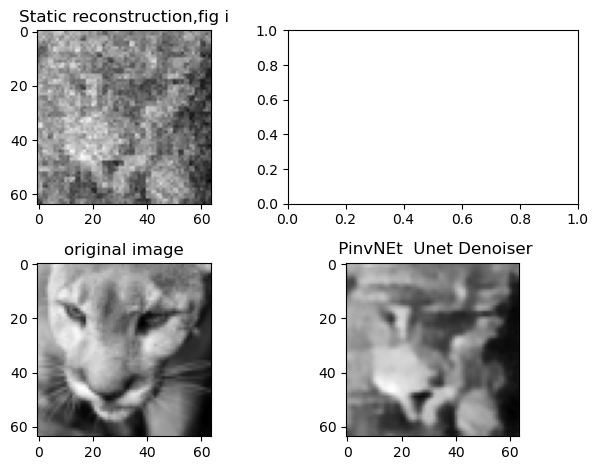

In [24]:
# %% STATIC RECO sans Pinv classe
from spyrit.core.nnet import Unet, ConvNet
from spyrit.core.train import load_net
import os

figure, axis = plt.subplots(2, 2)
with torch.no_grad():
    m = prep_op(y)
    f_stat = meas_op.pinv(m)

    axis[0,0].imshow(f_stat.view(h, w).cpu().numpy(), cmap='gray')
    axis[0,0].set_title('Static reconstruction,fig i')
    
    



# %% Reco with Pinv

"""
denoi_net_conv = ConvNet()
full_op = PinvNet ( noise_op , prep_op,denoi_net_conv )
#Load the pretrained w
with torch.no_grad():
    x_rec = full_op.reconstruct ( y )
    axis[0,1].imshow(x_rec.view(h, w).cpu().numpy(), cmap='gray')
    axis[0,1].set_title('PinvNet, no denoiser, fig j')
"""    


# %% Reco with Pinv and a Unet Denoiser
#Load the pretrained weights of the Unet

denoi_net = Unet ()
full_op = PinvNet ( noise_op , prep_op, denoi_net)
model_name = "pinv-net_BF_Unet_weight_decay_stl10_N0_10_N_64_M_1024_epo_50_lr_0.001_sss_10_sdr_0.5_bs_256.pth"
#entrainé sur un ordre des basse freq et sur des images 128
# recontruire avec un ordre de subsampling HF et réentrainé un modèle sur ça
# prendre un peut de BF et un de 
model_unet_path = os.path.join(model_folder, model_name)
load_net(model_unet_path, full_op, device, False)
with torch.no_grad():
    
    x_rec_2 = full_op . reconstruct ( y )
    axis[1,1].imshow(x_rec_2.view(h, w).cpu().numpy(), cmap='gray')
    axis[1,1].set_title(' PinvNEt  Unet Denoiser')
    
axis[1,0].imshow(x.view(h,w).cpu().numpy(), cmap='gray')
axis[1,0].set_title('original image')
plt.tight_layout()
plt.show()

In [29]:
from spyrit.misc.metrics import psnr_,ssim
from spyrit.misc.disp import imagesc
def test_model_on_data(model_name=None,model_type=nnet.Unet, pattern_order=None,alpha=10,und=4,img_size=64,verbose=False,model_path=None,nb_images=5):
    """
    Test a denoising model on a set of images.

    Parameters
    ----------
    model_name : str
        Name of the model to test.
    pattern_order : str
        Pattern order to use for the measurements.
    alpha : int
        Strength of the noise.
    img_size : int
        Size of the images to test on.
    verbose : bool
        Print out the shape of the input images.
    model_path : str
        Path to the model folder.

    Returns
    -------
    None
    """
    if (model_name is None) or (pattern_order is None):
        print("Please provide model name and pattern order")
        return
    image_folder = 'data/images'       # images for simulated measurements
    image_folder_full = Path.cwd() / Path(image_folder)
    if model_path is None:
        model_folder = 'model/'             # reconstruction models
        model_folder_full = Path.cwd() / Path(model_folder)
    else:
        model_folder_full = Path(model_path)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    model_unet_path = os.path.join(model_folder_full, model_name)

    transform = stats.transform_gray_norm(img_size)
    # define dataset and dataloader. `image_folder_full` should contain
    # a class folder with the images
    dataset = torchvision.datasets.ImageFolder(
        image_folder_full, 
        transform=transform
        )

    dataloader = torch.utils.data.DataLoader(
        dataset, 
        batch_size=nb_images, 
        shuffle=False
        )


    x, _ = next(iter(dataloader))
    if(verbose):
        print("Images loaded")
        print(f"Shape of input images: {x.shape}")


    # GETTING PATTERN ORDER
    M=img_size**2//und
    Ord_rec = choose_pattern_order(pattern_order, img_size)
    # Mask of order
    mask_basis = np.zeros((img_size, img_size))
    mask_basis.flat[:M] = 1
    mask = sort_by_significance(mask_basis, Ord_rec, axis="flatten")
    if (verbose):
        im = plt.imshow(mask)
        plt.title("Acquisition in " + pattern_order + " order", fontsize=20)
        add_colorbar(im, "bottom", size="20%")
    

    # SIMULATE MEASUREMENTS
    h=img_size
    meas_op = meas.HadamSplit(M, h, torch.from_numpy(Ord_rec))
    noise_op = noise.Poisson(meas_op, alpha)
    prep_op = prep.SplitPoisson(alpha, meas_op)
    torch.manual_seed(0)    # for reproducibility
    noise_op.alpha = alpha
    denoi_net = model_type()
    denoi_net.eval()
    # print("denoi",denoi_net.training)
    full_op = recon.PinvNet ( noise_op , prep_op, denoi_net)
    data_name = model_name
    model_unet_path = os.path.join(model_folder_full, data_name)
    train.load_net(model_unet_path, full_op, device, False)
    full_op.eval()
    psnr_tab=np.zeros((x.shape[0],1))
    ssim_tab=np.zeros((x.shape[0],1))
    psnr_tab_static=np.zeros((x.shape[0],1))
    ssim_tab_static=np.zeros((x.shape[0],1))
    if verbose:
        print ("valeur des pixels", x.min(), x.max())
    for i,image in enumerate(x):
        X1 = x[i:i+1, :, :, :].detach().clone()
        if (verbose):
            print("shape of X1 is ", X1.shape)
            plt.figure()
            imagesc(X1[0, 0, :, :],f'Original Image')
            # plt.title(f'Original image')
            plt.show()
        b, c, h, w = X1.shape
        y = noise_op(X1)
        m = prep_op(y)
        f_stat = meas_op.pinv(m)
        if verbose:
            #f_stat = meas_op.pinv(m)
            plt.figure()
            plt.imshow(f_stat.view(h, w).cpu().numpy(), cmap='gray')
            plt.title('Static reconstruction')
            plt.colorbar()
            plt.show()

        with torch.no_grad():
            
            x_rec = full_op.reconstruct(y)
            # print("fullop",full_op.training)
        if verbose:
            plt.figure()
            plt.imshow(x_rec.view(h, w).cpu().numpy(), cmap='gray')
            plt.title(f'Reconstructed image with pattern {pattern_order}')           
            plt.colorbar()
            plt.show()
        psnr_tab[i,0]=psnr_(X1.view(h, h).cpu().numpy(), x_rec.view(h, h).cpu().numpy())  
        ssim_tab[i,0]=ssim(X1.view(h, h).cpu().numpy(), x_rec.view(h, h).cpu().numpy())
        psnr_tab_static[i,0]=psnr_(X1.view(h, h).cpu().numpy(), f_stat.view(h, h).cpu().numpy())  
        ssim_tab_static[i,0]=ssim(X1.view(h, h).cpu().numpy(), f_stat.view(h, h).cpu().numpy())
    return psnr_tab,ssim_tab,psnr_tab_static,ssim_tab_static


# Test the Models on STL-10 test library
- testing the models

In [33]:
# 1st Model
nb_models=4 # number of diff models to test
size_db=  5 # number of images in the database
models = ['LF/HF/RAND','LF/HF/RAND','LF/HF/RAND','VARIANCE']
order_name="low_freq"

psnr_tab= np.zeros((nb_models,size_db)) # Stores the psnr for each model
ssim_tab= np.zeros((nb_models,size_db)) # Stores the ssim for each model
psnr_tab_static= np.zeros((nb_models,size_db)) # Stores the psnr for each model
ssim_tab_static= np.zeros((nb_models,size_db)) # Stores the ssim for each model

psnr,ssi,psnr_static,ssim_static = test_model_on_data(model_name='pinv-net_mult_acq_bf_hf_random_Unet_weight_decay_stl10_N0_10_N_64_M_1024_epo_30_lr_0.001_sss_10_sdr_0.5_bs_256.pth',pattern_order=order_name,alpha=10,img_size=64,verbose=False,nb_images=size_db)
psnr_tab[0,:]=psnr.squeeze()
ssim_tab[0,:]=ssi.squeeze()
psnr_tab_static[0,:]=psnr_static.squeeze()
ssim_tab_static[0,:]=ssim_static.squeeze()

#2nd model
order_name="low_freq"
psnr,ssi,psnr_static,ssim_static= test_model_on_data(model_name='pinv-net_mult_acq_bf_70_lf_random_Unet_weight_decay_stl10_N0_10_N_64_M_1024_epo_30_lr_0.001_sss_10_sdr_0.5_bs_256.pth',pattern_order=order_name,alpha=10,img_size=64,verbose=False,nb_images=size_db)
psnr_tab[1,:]=psnr.squeeze()
ssim_tab[1,:]=ssi.squeeze()
psnr_tab_static[1,:]=psnr_static.squeeze()
ssim_tab_static[1,:]=ssim_static.squeeze()

#3rd model
order_name="low_freq"
psnr,ssi,psnr_static,ssim_static= test_model_on_data(model_name='pinv-net_mult_acq_bf_70corr_random_Unet_weight_decay_stl10_N0_10_N_64_M_1024_epo_30_lr_0.001_sss_10_sdr_0.5_bs_256.pth',pattern_order=order_name,alpha=10,img_size=64,verbose=False,nb_images=size_db)
psnr_tab[2,:]=psnr.squeeze()
ssim_tab[2,:]=ssi.squeeze()
psnr_tab_static[2,:]=psnr_static.squeeze()
ssim_tab_static[2,:]=ssim_static.squeeze()

order_name="low_freq"
psnr,ssi,psnr_static,ssim_static= test_model_on_data(model_name='pinv-net_variance_Unet_weight_decay_stl10_N0_10_N_64_M_1024_epo_30_lr_0.001_sss_10_sdr_0.5_bs_256.pth',pattern_order=order_name,alpha=10,img_size=64,verbose=False,nb_images=size_db)
psnr_tab[3,:]=psnr.squeeze()
ssim_tab[3,:]=ssi.squeeze()
psnr_tab_static[3,:]=psnr_static.squeeze()
ssim_tab_static[3,:]=ssim_static.squeeze()

Using device: cpu
Model Loaded: c:\Users\marti\OneDrive - INSA Lyon\5GE\TDSI\Projet\fork_sami\image_recontruction_ML-1\2024_tdsi\model\pinv-net_mult_acq_bf_hf_random_Unet_weight_decay_stl10_N0_10_N_64_M_1024_epo_30_lr_0.001_sss_10_sdr_0.5_bs_256.pth
Using device: cpu
Model Loaded: c:\Users\marti\OneDrive - INSA Lyon\5GE\TDSI\Projet\fork_sami\image_recontruction_ML-1\2024_tdsi\model\pinv-net_mult_acq_bf_70_lf_random_Unet_weight_decay_stl10_N0_10_N_64_M_1024_epo_30_lr_0.001_sss_10_sdr_0.5_bs_256.pth
Using device: cpu
Model Loaded: c:\Users\marti\OneDrive - INSA Lyon\5GE\TDSI\Projet\fork_sami\image_recontruction_ML-1\2024_tdsi\model\pinv-net_mult_acq_bf_70corr_random_Unet_weight_decay_stl10_N0_10_N_64_M_1024_epo_30_lr_0.001_sss_10_sdr_0.5_bs_256.pth
Using device: cpu
Model Loaded: c:\Users\marti\OneDrive - INSA Lyon\5GE\TDSI\Projet\fork_sami\image_recontruction_ML-1\2024_tdsi\model\pinv-net_variance_Unet_weight_decay_stl10_N0_10_N_64_M_1024_epo_30_lr_0.001_sss_10_sdr_0.5_bs_256.pth


- Plotting

<Figure size 1200x600 with 0 Axes>

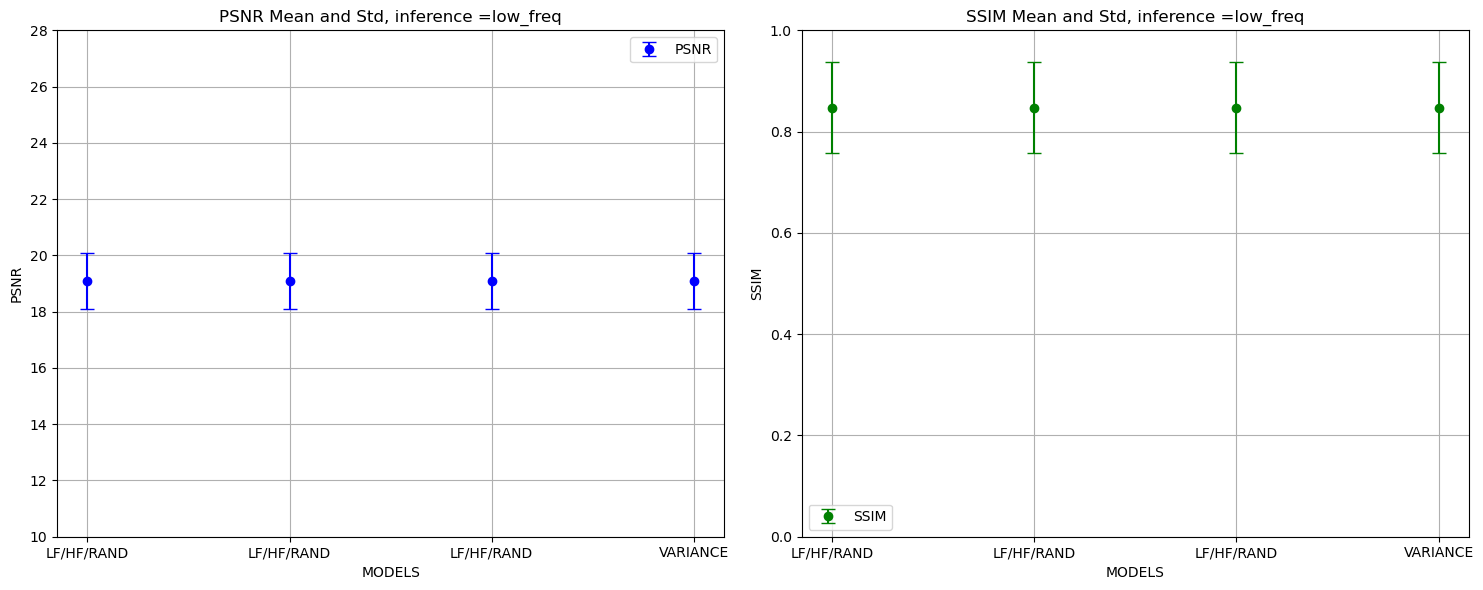

In [35]:
#  Plotting the results in an error bar plot

psnr_mean = psnr_tab_static.mean(axis=1)
psnr_std = psnr_tab_static.std(axis=1)

ssim_mean = ssim_tab_static.mean(axis=1)
ssim_std = ssim_tab_static.std(axis=1)

# Plotting the results
x = np.arange(psnr_tab.shape[0])  # Number of models vector

plt.figure(figsize=(12, 6))
plt.figure(figsize=(15, 6))

# Plot PSNR
plt.subplot(1, 2, 1) #Subplot for PSNR plotting
plt.errorbar(x, psnr_mean, yerr=psnr_std, fmt='o', capsize=5, label='PSNR', color='blue')
# plt.xticks(x, [f'Model {i+1}' for i in x])
plt.xticks(x, models)
plt.title('PSNR Mean and Std, inference ='+ order_name)
plt.xlabel('MODELS')
plt.ylabel('PSNR')
plt.ylim(10,28)
plt.grid(True)
plt.legend()

# Plot SSIM
plt.subplot(1, 2, 2)
plt.errorbar(x, ssim_mean, yerr=ssim_std, fmt='o', capsize=5, label='SSIM', color='green')
# plt.xticks(x, [f'Model {i+1}' for i in x])
plt.xticks(x,models)
plt.title('SSIM Mean and Std, inference ='+ order_name)
plt.xlabel('MODELS')
plt.ylabel('SSIM')
plt.ylim(0,1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()